In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, IterableDataset
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from itertools import combinations
import random
from tqdm import tqdm

import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim

import itertools

In [3]:
data = np.load(r"./splitted_cifar10_dataset.npz")

In [4]:
x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]

In [5]:
y_val.shape

(10000, 1)

#### Implement dataloader for CIFAR10

In [6]:
class MyIterableDataset(IterableDataset):
    def __init__(self, data, targets, ucc_start, ucc_end, transform=None):
        super(MyIterableDataset).__init__()
        self.data = data
        self._num_instances_per_bag = 64
        self._ucc_end = ucc_end
        self._ucc_start = ucc_start
        self._num_classes = self._ucc_end - self._ucc_start + 1
        self._num_samples_per_class = int(self._num_instances_per_bag/self._num_classes)
        self.targets = targets #torch.LongTensor(targets)
        self.transform = transform
        self._num_digits = len(np.unique(self.targets))
        self.digit_dict = self._initialise_digit_dict()
        self.class_dict = self._initialise_class_dict()
        self._classes = [0,1,2,3,4,5,6,7,8,9]
        
    def _initialise_digit_dict(self):
        digit_dict = dict()
        for i in range(self._num_digits):
            digit_key = 'digit' + str(i)
            digit_value = i

            temp_digit_dict = dict()

            temp_digit_dict['value'] = digit_value
            temp_digit_dict['indices'] = np.where(self.targets == digit_value)[0]
            temp_digit_dict['num_dataset'] = len(temp_digit_dict['indices'])
            digit_dict[digit_key] = temp_digit_dict
        return digit_dict

    def _initialise_class_dict(self):
        elements_arr = np.arange(self._num_digits)
        class_dict = dict()
        for i in range(self._num_classes):
            class_key = 'class_' + str(i)

            temp_class_dict = dict()
            elements_list = list()
            for j in combinations(elements_arr,i+self._ucc_start):
                elements_list.append(np.array(j))

            elements_array = np.array(elements_list)
            np.random.shuffle(elements_array)
            temp_class_dict['tuples_arr'] = elements_array
            temp_class_dict['num_tuples'] = len(temp_class_dict['tuples_arr'])
            temp_class_dict['index'] = 0

            class_dict[class_key] = temp_class_dict

        return class_dict        
        
    def __iter__(self):
        return self
        
    def __next__(self):
        # uniformly sample each ucc according to _num_instances_per_bag
        indices_list = list()
        labels_list = list()

        ucc_class = random.randint(self._ucc_start, self._ucc_end)
        # print(f"ucc_class {ucc_class}")
        # for i in range(self._num_classes):
            # for each ucc class
            # for _ in range(self._num_samples_per_class):
                # For each bag, sample which classes to pick from
                # random.sample takes without replacement
        classes_to_sample = random.sample(self._classes, ucc_class)
                
        num_elements = len(classes_to_sample)
        num_instances_per_element = self._num_instances_per_bag // num_elements
        remainder_size = self._num_instances_per_bag % num_elements
                
                # for each class, sample num_instances_arr. each element in num_instances_arr is number of samples from class
        num_instances_arr = np.repeat(num_instances_per_element,num_elements)
        num_instances_arr[:remainder_size] += 1
        
        for k in range(num_elements):
            digit_key = 'digit' + str(classes_to_sample[k])
            # print(digit_key)
            # number of instances to sample from kth class
            # print(f"digit_key {digit_key}")
            num_instances = num_instances_arr[k]
            
            np.random.shuffle(self.digit_dict[digit_key]['indices'])
            indices_list += list(self.digit_dict[digit_key]['indices'][:num_instances])
            # print(f"indices_list {indices_list}")
            
        labels_list += list(self.generate_one_hot(ucc_class-1, self._num_classes))
        # print(f"labels_list {labels_list}")            

        indices_arr = np.array(indices_list)
        labels_arr = np.array(labels_list)
        
        # print(f"indices_arr {indices_arr.shape}")
        # print(f"labels_arr {labels_arr.shape}")
        samples_arr = self.get_sample_data_train(indices_arr)
        # print(f"samples_arr {samples_arr.shape}")
        # samples_arr = np.reshape(samples_arr, (-1,samples_arr.shape[1],samples_arr.shape[2],samples_arr.shape[3]))
        # print(f"labels_arr {labels_arr}")
        labels_arr = np.reshape(labels_arr, (-1,self._num_classes))
        # print(f"labels_arr {labels_arr}")
        labels_arr = np.squeeze(labels_arr)
        samples_data = samples_arr
        # samples_data = np.transpose(samples_arr,(1,0,2,3,4))

        samples = list(samples_data)
        # print(f"samples {np.array(samples).shape}")
        labels = list(labels_arr)
        # print(f"labels {labels}")
        if self.transform:
            num_images = samples_data.shape[0]
            for i in range(num_images):
                samples[i] = self.transform(samples[i])
        # print(f"samples {np.array(samples).shape}")
        # print(f"labels {labels}")
        np.random.shuffle(samples)
        return torch.stack(samples), torch.Tensor(np.array(labels))
        
    def get_sample_data_train(self, indices_arr):
        sample = np.array(self.data[indices_arr,:,:,:])
        # print('Sample shape:{}'.format(sample.shape))
        return sample

    def generate_one_hot(self, num_class, ucc_class_number):
        one_hot = np.zeros(ucc_class_number, dtype=np.int32)
        one_hot[num_class] = 1
        return one_hot

In [7]:
mean = x_train.mean(axis=(0,1,2))/255
std = x_train.std(axis=(0,1,2))/255
print(mean,std)

[0.49132227 0.48193014 0.44611377] [0.24703714 0.24348286 0.26164097]


In [8]:
ucc_start = 1
ucc_end = 4

In [9]:
train_dataset = MyIterableDataset(x_train, y_train, ucc_start=ucc_start, ucc_end=ucc_end, transform = \
                                  transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), \
                                      transforms.RandomRotation(10),\
                                      transforms.Normalize(mean, std)]))

In [10]:
val_dataset = MyIterableDataset(x_val, y_val, ucc_start=ucc_start, ucc_end=ucc_end, transform = transforms.Compose([
                                                                                transforms.ToTensor()]))

In [11]:
dataset, labels = next(train_dataset)

In [12]:
def plot_images(dataset):
# Create a subplot with 5 rows and 4 columns to display 20 images
    num_rows = 8
    num_cols = 8
    # Set up the figure and axis
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    # print(dataset.shape)
    # Loop through the image paths and display each image
    for i in range(len(dataset)):
        # Read the image
        # image_path = np.array(dataset[i])
        
        img = np.swapaxes(np.swapaxes(dataset[i], 0,2), 0,1)
        # print(np.swapaxes(image_path, 0,2).shape)
        # img = np.swapaxes((image_path, 0,2), 0,1)
    
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for better visualization
        axes[i].set_title(f'Image {i + 1}')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

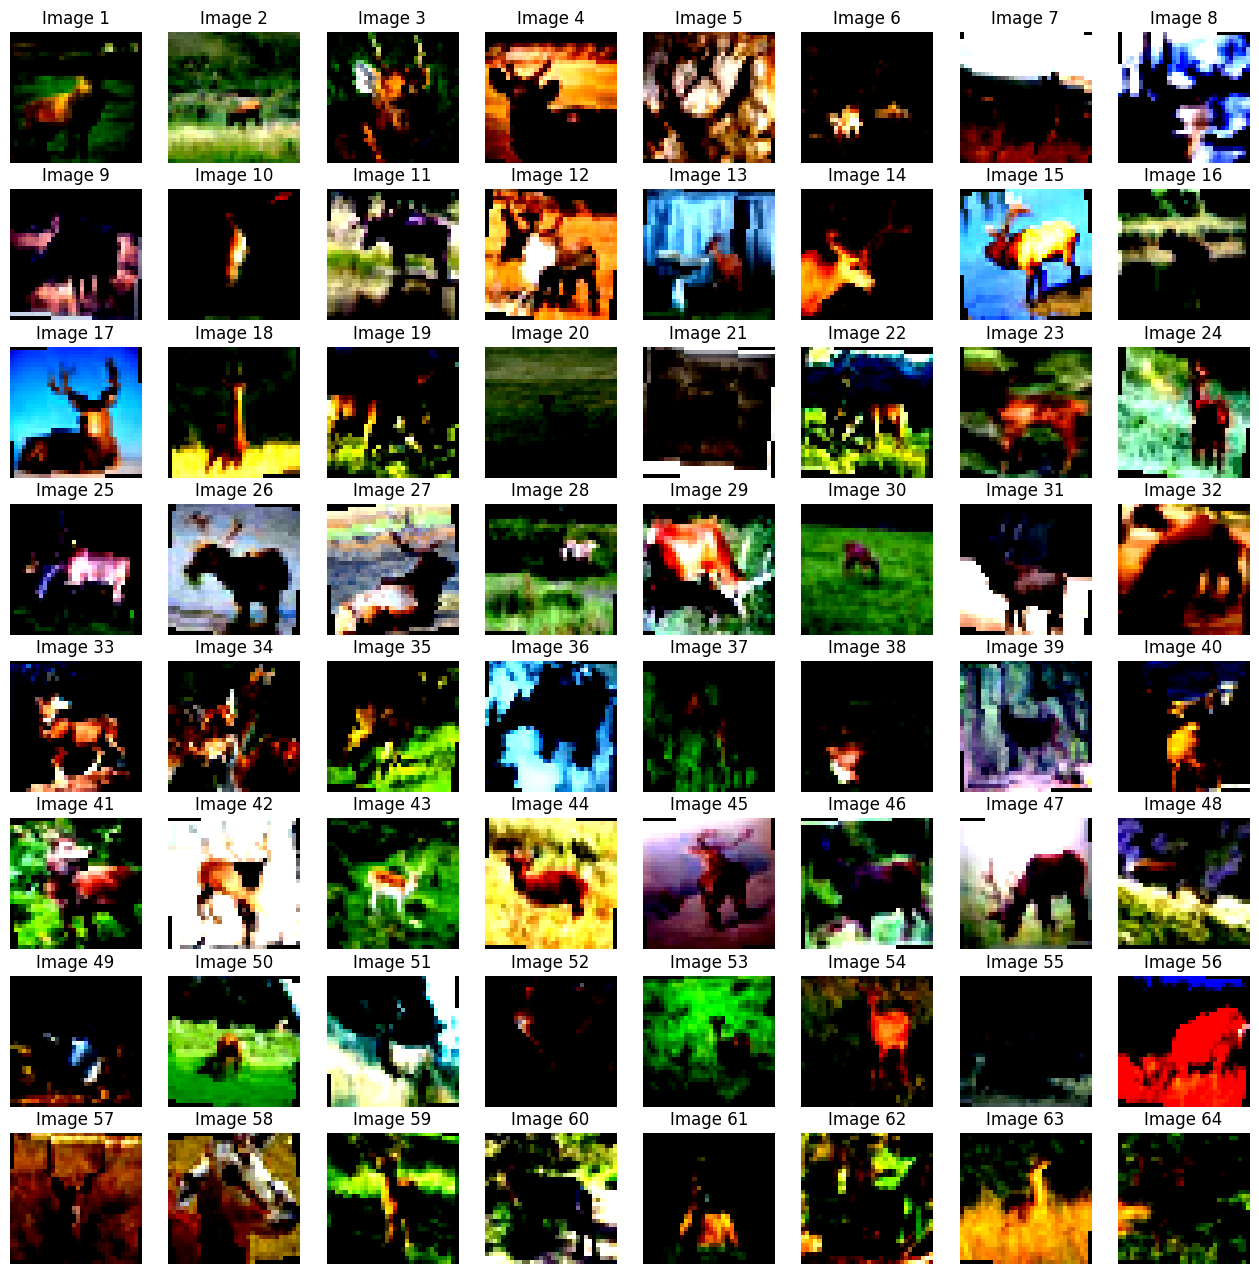

In [13]:
plot_images(dataset)

In [14]:
# train_dataloader = DataLoader(train_dataset, batch_size=15)

In [15]:
# val_dataloader = DataLoader(val_dataset, batch_size=256)

#### Implement autoencoder module

In [16]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [17]:
class ResidualZeroPaddingBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        first_block=False,
        down_sample=False,
        up_sample=False,
    ):
        super(ResidualZeroPaddingBlock, self).__init__()
        self.first_block = first_block
        self.down_sample = down_sample
        self.up_sample = up_sample

        if self.up_sample:
            self.upsampling = nn.Upsample(scale_factor=2, mode="nearest")

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            stride=2 if self.down_sample else 1,
        )
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.skip_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=2 if self.down_sample else 1,
        )

        # Initialize the weights and biases
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.1)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.1)
        nn.init.xavier_uniform_(self.skip_conv.weight)

    def forward(self, x):
        if self.first_block:
            x = F.relu(x)
            if self.up_sample:
                x = self.upsampling(x)
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
            if x.shape != out.shape:
                x = self.skip_conv(x)
        else:
            out = F.relu(self.conv1(x))
            out = F.relu(self.conv2(out))

        return x + out


class WideResidualBlocks(nn.Module):
    def __init__(
        self, in_channels, out_channels, n, down_sample=False, up_sample=False
    ):
        super(WideResidualBlocks, self).__init__()
        self.blocks = nn.Sequential(
            *[
                ResidualZeroPaddingBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    first_block=(i == 0),
                    down_sample=down_sample,
                    up_sample=up_sample,
                )
                for i in range(n)
            ]
        )

    def forward(self, x):
        return self.blocks(x)


class Reshape(nn.Module):
    def __init__(self, *target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape

    def forward(self, x):
        return x.view(x.size(0), *self.target_shape)


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.num_bins = 11
        self.sigma = 0.1
        self.patch_model = nn.Sequential(
            nn.Conv2d(
                3,
                16,
                kernel_size=3,
                padding=1,
            ),
            WideResidualBlocks(
                16,
                32,
                1,
            ),
            WideResidualBlocks(
                32,
                64,
                1,
                down_sample=True,
            ),
            WideResidualBlocks(
               64,
                128,
                1,
                down_sample=True,
            ),
            nn.Conv2d(
                128,
                1,
                kernel_size=5,
                padding=1,
            ),
            # nn.Sigmoid(),
            # nn.Flatten(),
            # nn.Linear(
            #     8192,
            #     10,
            #     bias=False,
            # ),
            nn.Sigmoid(),
        )

    def _forward_impl(self, x):
        x = self.patch_model(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


In [18]:

class Decoder(nn.Module):
    def __init__(self, num_hiddens):
        super(Decoder, self).__init__()
        upscale_size = 256

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=1, 
                                                out_channels=upscale_size//4,
                                                kernel_size=2, 
                                                stride=2, padding=0)

        self.bn1 = nn.BatchNorm2d(upscale_size//4)

        self._conv_trans_3 = nn.ConvTranspose2d(in_channels=upscale_size//4, 
                                        out_channels=upscale_size//16,
                                        kernel_size=4, 
                                        stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(upscale_size//16)

        self._conv_trans_5 = nn.ConvTranspose2d(in_channels=upscale_size//16, 
                                                out_channels=upscale_size//32,
                                                kernel_size=6, 
                                                stride=1, padding=0, output_padding = 0)
        self.bn5 = nn.BatchNorm2d(upscale_size//32)
        
        self._conv_trans_6 = nn.ConvTranspose2d(in_channels=upscale_size//32, 
                                        out_channels=3,
                                        kernel_size=6, 
                                        stride=1, padding=1)
        
        self.unpooling3 = nn.Upsample(scale_factor=2, mode='nearest')
        nn.init.xavier_uniform_(self._conv_trans_1.weight)
        nn.init.xavier_uniform_(self._conv_trans_3.weight)
        nn.init.xavier_uniform_(self._conv_trans_5.weight)
        
    def forward(self, x):

        x = self._conv_trans_1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self._conv_trans_3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self._conv_trans_5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self._conv_trans_6(x)

        x = F.sigmoid(x)
        
        return x

class Autoencoder_2d(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder_2d,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(10)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
encoder_pretrained = Encoder()
autoencoder = Autoencoder_2d(encoder_pretrained)

In [20]:
summary(encoder_pretrained, (3,32,32))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1, 6, 6]             --
|    └─Conv2d: 2-1                                 [-1, 16, 32, 32]          448
|    └─WideResidualBlocks: 2-2                     [-1, 32, 32, 32]          --
|    |    └─Sequential: 3-1                        [-1, 32, 32, 32]          14,432
|    └─WideResidualBlocks: 2-3                     [-1, 64, 16, 16]          --
|    |    └─Sequential: 3-2                        [-1, 64, 16, 16]          57,536
|    └─WideResidualBlocks: 2-4                     [-1, 128, 8, 8]           --
|    |    └─Sequential: 3-3                        [-1, 128, 8, 8]           229,760
|    └─Conv2d: 2-5                                 [-1, 1, 6, 6]             3,201
|    └─Sigmoid: 2-6                                [-1, 1, 6, 6]             --
Total params: 305,377
Trainable params: 305,377
Non-trainable params: 0
Total mult-adds (M): 1.77


Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1, 6, 6]             --
|    └─Conv2d: 2-1                                 [-1, 16, 32, 32]          448
|    └─WideResidualBlocks: 2-2                     [-1, 32, 32, 32]          --
|    |    └─Sequential: 3-1                        [-1, 32, 32, 32]          14,432
|    └─WideResidualBlocks: 2-3                     [-1, 64, 16, 16]          --
|    |    └─Sequential: 3-2                        [-1, 64, 16, 16]          57,536
|    └─WideResidualBlocks: 2-4                     [-1, 128, 8, 8]           --
|    |    └─Sequential: 3-3                        [-1, 128, 8, 8]           229,760
|    └─Conv2d: 2-5                                 [-1, 1, 6, 6]             3,201
|    └─Sigmoid: 2-6                                [-1, 1, 6, 6]             --
Total params: 305,377
Trainable params: 305,377
Non-trainable params: 0
Total mult-adds (M): 1.77


In [21]:
summary(autoencoder, (3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 1, 6, 6]             --
|    └─Sequential: 2-1                   [-1, 1, 6, 6]             --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          448
|    |    └─WideResidualBlocks: 3-2      [-1, 32, 32, 32]          14,432
|    |    └─WideResidualBlocks: 3-3      [-1, 64, 16, 16]          57,536
|    |    └─WideResidualBlocks: 3-4      [-1, 128, 8, 8]           229,760
|    |    └─Conv2d: 3-5                  [-1, 1, 6, 6]             3,201
|    |    └─Sigmoid: 3-6                 [-1, 1, 6, 6]             --
├─Decoder: 1-2                           [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-2              [-1, 64, 12, 12]          320
|    └─BatchNorm2d: 2-3                  [-1, 64, 12, 12]          128
|    └─ConvTranspose2d: 2-4              [-1, 16, 24, 24]          16,400
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 1, 6, 6]             --
|    └─Sequential: 2-1                   [-1, 1, 6, 6]             --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          448
|    |    └─WideResidualBlocks: 3-2      [-1, 32, 32, 32]          14,432
|    |    └─WideResidualBlocks: 3-3      [-1, 64, 16, 16]          57,536
|    |    └─WideResidualBlocks: 3-4      [-1, 128, 8, 8]           229,760
|    |    └─Conv2d: 3-5                  [-1, 1, 6, 6]             3,201
|    |    └─Sigmoid: 3-6                 [-1, 1, 6, 6]             --
├─Decoder: 1-2                           [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-2              [-1, 64, 12, 12]          320
|    └─BatchNorm2d: 2-3                  [-1, 64, 12, 12]          128
|    └─ConvTranspose2d: 2-4              [-1, 16, 24, 24]          16,400
|    └─BatchNorm2d: 2-5                  [-1, 16, 24, 24]     

#### Implement KDE module

In [22]:
class KDELayer(nn.Module):
   
    def __init__(self, num_features, num_nodes, sigma, batch_size):
        super(KDELayer, self).__init__()
        self.num_features = torch.tensor(num_features).to(self.set_cuda())
        self.num_nodes = torch.tensor(num_nodes).to(self.set_cuda())
        self.sigma = torch.tensor(sigma).to(self.set_cuda())
        self.batch_size = torch.tensor(batch_size).to(self.set_cuda())
        # self.data = data

    def kde(self, data):
        num_nodes = self.num_nodes
        sigma = self.sigma
        device = data.device
        # print(f"data.shape {data.shape}")
        # data shape: (batch_size, num_instances, num_features)
        batch_size, num_instances, num_features = data.shape

        # Create sample points
        k_sample_points = (
            torch.linspace(0, 1, steps=num_nodes)
            .repeat(batch_size, num_instances, 1)
            .to(self.set_cuda())
        )
        # print(f"k_sample_points.shape {k_sample_points.shape}")
        # Calculate constants
        k_alpha = 1 / torch.sqrt(2 * torch.pi * sigma**2)
        k_beta = -1 / (2 * sigma**2)

        # Iterate over features and calculate kernel density estimation for each feature
        out_list = []
        for i in range(num_features):
            one_feature = data[:, :, i : i + 1].repeat(1, 1, num_nodes).to(self.set_cuda())

            k_diff_2 = (k_sample_points - one_feature) ** 2
            k_result = k_alpha * torch.exp(k_beta * k_diff_2)
            k_out_unnormalized = k_result.sum(dim=1)

            k_norm_coeff = k_out_unnormalized.sum(dim=1).view(-1, 1)
            k_out = k_out_unnormalized / k_norm_coeff.repeat(
                1, k_out_unnormalized.size(1)
            )
            # print(f"k_out.shape {k_out.shape}")
            out_list.append(k_out)

        # Concatenate the results
        concat_out = torch.cat(out_list, dim=-1)
        return concat_out
        
    def forward(self,data):
        # Call the kde function within the forward
        data = nn.Flatten(start_dim=2)(data)
        kde_output = self.kde(data)
        return kde_output
        
    def set_cuda(self):
        if torch.cuda.is_available():
            return torch.device("cuda")
            # print("GPU is available and being used")
        else:
            return torch.device("cpu")
            # print("GPU is not available, using CPU instead")

#### Distribution regression module

In [23]:
class DRNModule(nn.Module):
   
    def __init__(self, num_class):
        super(DRNModule, self).__init__()
        self.fc1 = nn.Linear(11*36,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,num_class)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        # Call the kde function within the forward
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # x = F.softmax(x,dim=1)
        return x

#### Realise losses

In [24]:
class UCCModel(nn.Module):
    def __init__(self, ucc_start, ucc_end, batch_size):
        super(UCCModel, self).__init__()
        self.ucc_end = ucc_end
        self.ucc_start = ucc_start
        self.feature_extractor = Encoder()

        self.decoder = Decoder(32)
        self.kde = KDELayer(num_features=36, num_nodes=11, sigma=0.1, batch_size=batch_size)
        self.drn = DRNModule(ucc_end - ucc_start + 1)

        
    def forward(self,x):

        batch_size, num_instances, num_channel, _, _ = x.shape
        x = x.view(-1, num_channel, x.shape[-2], x.shape[-1])        
        x_features = self.feature_extractor(x)
        ae_output = self.decoder(x_features)
        features = x_features.view(batch_size, num_instances, x_features.shape[-1],x_features.shape[-1])
        x_kde = self.kde(features)
        x_ucc = self.drn(x_kde)

        return ae_output, x_ucc


In [25]:
class Trainer():
    def __init__(self, ucc_start, ucc_end):
        self.model_name = 'UCC_Trainer'
        self.ucc_start = ucc_start
        self.ucc_end = ucc_end
        self.alpha = 0.5
        self.batch_size = 20
        self.batch_size_test = 24
        self.learning_rate = 1e-3
        self.num_epochs = 10
        self.data = np.load(r"./splitted_cifar10_dataset.npz")
        self.x_train = self.data["x_train"]
        self.y_train = self.data["y_train"]
        self.x_val = self.data["x_val"]
        self.y_val = self.data["y_val"]
        self.mean = self.x_train.mean(axis=(0,1,2))/255
        self.std = self.x_train.std(axis=(0,1,2))/255
        self._base_transform_train = [transforms.ToTensor(), transforms.RandomHorizontalFlip(), \
                                      transforms.RandomRotation(10), \
                                      transforms.Normalize(mean, std)
                                     ]
        self._base_transform_test = [transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)
                                    ]
        self.train_dataset = MyIterableDataset(self.x_train, self.y_train, ucc_start=self.ucc_start, \
                                          ucc_end=self.ucc_end, \
                                          transform = transforms.Compose(self._base_transform_train))
        self.test_dataset = MyIterableDataset(self.x_val, self.y_val, \
                                             ucc_start=self.ucc_start, ucc_end=self.ucc_end, \
                                          transform = transforms.Compose(self._base_transform_test))
        
        self.model = UCCModel(ucc_start, ucc_end, self.batch_size)
        
        self.training_loss = []
        self.training_ucc_loss = []
        self.training_ae_loss = []
        self.training_acc = []
        self.testing_loss = []
        self.testing_acc = []
        self.valid_loss_min = np.Inf
        self.best_epoch = 0
        self.best_epoch_state = None

    def train(self):
        
        device = self.set_cuda()
        self.model.to(device)
        optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate)

        classification_criterion = nn.CrossEntropyLoss()#nn.NLLLoss()
        autoencoder_criterion = nn.MSELoss()

        train_loader = self.get_train_dataloader()
        for epoch in tqdm(range(1, self.num_epochs+1)):
            self.model.train()
            train_loss = 0.0
            train_loss_ae = 0.0
            train_loss_ucc = 0.0
            train_correct = 0
            train_total = 0
            iteration_in_batch = 0
            for _ in range(int(len(self.x_train)/self.batch_size)):
                images, labels = next(iter(train_loader))
                
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                x_reconstructed, ucc_pred = self.model(images)
                loss_ae = autoencoder_criterion(x_reconstructed, images.reshape(-1, images.shape[-3], images.shape[-2], images.shape[-1]))

                loss_ucc = classification_criterion(ucc_pred, labels)
    
                loss = self.alpha * loss_ucc + (1-self.alpha) * loss_ae
                
                _, predicted = torch.max(ucc_pred.data, 1)

                predicted_one_hot = torch.nn.functional.one_hot(predicted, \
                                                                num_classes=(self.ucc_end-self.ucc_start+1))

                train_total += labels.size(0)
                train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

                self.x_reconstructed = x_reconstructed

                iteration_in_batch += 1

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_loss_ae += loss_ae.item()
                train_loss_ucc += loss_ucc.item()
                
            
            train_loss_epoch = train_loss/(len(self.x_train)/self.batch_size)
            train_loss_ucc_epoch = train_loss_ucc/(len(self.x_train)/self.batch_size)
            train_loss_ae_epoch = train_loss_ae/(len(self.x_train)/self.batch_size)
            train_acc = train_correct/train_total
            self.training_acc.append(train_acc)
            self.training_loss.append(train_loss_epoch)
            
            self.training_ucc_loss.append(train_loss_ucc_epoch)
            self.training_ae_loss.append(train_loss_ae_epoch)
            
            print ('Episode [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f} %' 
                               .format(epoch, self.num_epochs, train_loss_epoch, train_acc * 100))
            self.eval_kde(epoch)

    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
        
    def get_test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size_test)

    def set_cuda(self):
        if torch.cuda.is_available():
            return torch.device("cuda")
            # print("GPU is available and being used")
        else:
            return torch.device("cpu")
            # print("GPU is not available, using CPU instead")

    # Create a subplot with 5 rows and 4 columns to display 20 images
    def plot_image(self,dataset,name=''):
        num_rows = 8
        num_cols = 8
        
        # Set up the figure and axis
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
        
        # Flatten the axes array for easier iteration
        axes = axes.flatten()
        
        # Loop through the image paths and display each image
        for i in range(min(len(dataset), num_rows * num_cols)):
            # Read the image
            # image_path = np.array(dataset[i])
            img = np.swapaxes(np.swapaxes(dataset[i].cpu().detach().numpy(), 0,2), 0,1)

            # Display the image
            axes[i].imshow(img)
            axes[i].axis('off')  # Turn off axis labels for better visualization
            axes[i].set_title(f'Image {i + 1}')
        
        # Adjust layout to prevent clipping of titles
        plt.tight_layout()
        plt.title(name)
        # Show the plot
        plt.show()
        
    def eval_kde(self, epoch=1):
        device = self.set_cuda()
        self.model.to(device)
        self.model.eval()
        val_loss_list = []
        val_acc_list = []
        val_dataloader = self.get_test_dataloader()
        classification_criterion = nn.CrossEntropyLoss()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        for _ in range(int(len(self.x_val)/self.batch_size_test)):
            images, labels = next(iter(val_dataloader))
            
            images = images.to(device)
            labels = labels.to(device)
            x_reconstructed, ucc_pred = self.model(images)
            _, predicted = torch.max(ucc_pred.data, 1)
            loss_ucc = classification_criterion(ucc_pred, labels)
            loss = loss_ucc
            test_total += labels.size(0)
            test_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

            test_loss += loss.item()

            
        test_loss_epoch = test_loss/(len(self.y_train)/self.batch_size_test)
        test_acc = test_correct/test_total
        self.testing_loss.append(test_loss_epoch)
        self.testing_acc.append(test_acc)
        print ('Episode [{}], Validation Loss: {:.4f}, Test Accuracy: {:.4f} %' 
                   .format(epoch, test_loss_epoch, test_acc * 100))
        self.model.train()

    def plot_loss(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_ucc_loss[:self.num_epochs], label="Training UCC Loss")
        plt.plot(ep, self.training_ae_loss[:self.num_epochs], label="Training AE Loss")
        plt.plot(ep, self.training_loss[:self.num_epochs], label="Overall Training Loss")
        plt.plot(ep, self.testing_loss[:self.num_epochs], label="Test UCC Loss")
        
        plt.title("Loss against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    def plot_acc(self):
        ep = [x for x in range(self.num_epochs)]
        plt.plot(ep, self.training_acc[:self.num_epochs], label="Training Accuracy")
        plt.plot(ep, self.testing_acc[:self.num_epochs], label="Test Accuracy")
        plt.title("Accuracy against Number of Epochs")
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

In [26]:
trainer = Trainer(1,4)

In [40]:
## Trained using alpha = 0 for 2 epochs
trainer.model.load_state_dict(torch.load(r'./saved_model-wideresnet.pth'))
# trainer.eval_kde()

trainer.train()

  0%|                                                                                               | 0/10 [00:00<?, ?it/s]

Episode [1/10], Loss: 0.6380, Train Accuracy: 36.7600 %


 10%|████████▍                                                                           | 1/10 [07:57<1:11:36, 477.33s/it]

Episode [1], Validation Loss: 0.2810, Test Accuracy: 46.0637 %
Episode [2/10], Loss: 0.5367, Train Accuracy: 50.0675 %


 20%|████████████████▊                                                                   | 2/10 [15:54<1:03:37, 477.20s/it]

Episode [2], Validation Loss: 0.2387, Test Accuracy: 56.1198 %
Episode [3/10], Loss: 0.5018, Train Accuracy: 54.4125 %


 30%|█████████████████████████▊                                                            | 3/10 [23:51<55:40, 477.22s/it]

Episode [3], Validation Loss: 0.2172, Test Accuracy: 62.0893 %
Episode [4/10], Loss: 0.4683, Train Accuracy: 60.3400 %


 40%|██████████████████████████████████▍                                                   | 4/10 [31:52<47:51, 478.56s/it]

Episode [4], Validation Loss: 0.2024, Test Accuracy: 67.0172 %
Episode [5/10], Loss: 0.4504, Train Accuracy: 62.7975 %


 50%|███████████████████████████████████████████                                           | 5/10 [39:44<39:41, 476.36s/it]

Episode [5], Validation Loss: 0.1920, Test Accuracy: 70.2123 %
Episode [6/10], Loss: 0.4350, Train Accuracy: 64.9450 %


 60%|███████████████████████████████████████████████████▌                                  | 6/10 [47:39<31:43, 475.79s/it]

Episode [6], Validation Loss: 0.1736, Test Accuracy: 74.1186 %
Episode [7/10], Loss: 0.4224, Train Accuracy: 66.3750 %


 70%|████████████████████████████████████████████████████████████▏                         | 7/10 [55:37<23:49, 476.40s/it]

Episode [7], Validation Loss: 0.2413, Test Accuracy: 55.2784 %
Episode [8/10], Loss: 0.4144, Train Accuracy: 66.9150 %


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [1:03:34<15:53, 476.62s/it]

Episode [8], Validation Loss: 0.1775, Test Accuracy: 70.4026 %
Episode [9/10], Loss: 0.4023, Train Accuracy: 68.2025 %


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [1:11:26<07:55, 475.27s/it]

Episode [9], Validation Loss: 0.1723, Test Accuracy: 70.4127 %
Episode [10/10], Loss: 0.3930, Train Accuracy: 69.6800 %


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [1:19:23<00:00, 476.39s/it]

Episode [10], Validation Loss: 0.1677, Test Accuracy: 73.1571 %


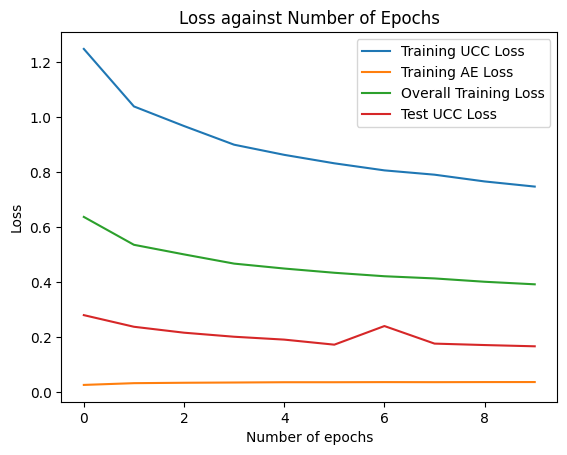

In [41]:
trainer.plot_loss()

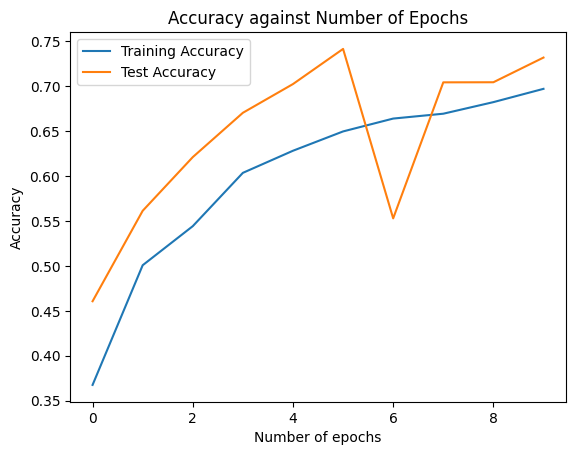

In [42]:
trainer.plot_acc()

In [43]:
torch.save(trainer.model.state_dict(), r'./saved_model-wideresnet-10-epoch.pth')

In [28]:
m_color = [
    "#ffe119",
    "#4363d8",
    "#f58231",
    "#911eb4",
    "#46f0f0",
    "#f032e6",
    "#bcf60c",
    "#fabebe",
    "#008080",
    "#e6beff",
    "#9a6324",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#ffd8b1",
    "#000075",
    "#808080",
    "#ffffff",
    "#000000",
    "#e6194b",
    "#3cb44b",
]

In [29]:
def visualize_distributions(distributions, classes):
    num_bins = 11
    hist_max = np.amax(distributions)
    num_features = int(distributions.shape[1] / num_bins)
    fig, ax = plt.subplots(len(classes), num_features, figsize=(16, 10))
    fig.subplots_adjust(left=0.05, right=0.97, top=0.94, bottom=0.1)

    legend_color = list()
    for h in range(num_features):
        temp_hist_data = distributions[:, h * num_bins : (h + 1) * num_bins]

        for c in range(len(classes)):
            data = temp_hist_data[c, :]

            ax1 = ax[c, h]
            (bp,) = ax1.plot(np.arange(0, 1.1, 0.1), data, c=m_color[c], linestyle="-")

            if h == (num_features - 1):
                legend_color.append(bp)

            ax1.tick_params(axis="both", labelsize=6)
            ax1.tick_params(axis="x", rotation=90)
            ax1.set_ylim((-0.05, hist_max + 0.05))
            ax1.yaxis.set_ticks(np.arange(0, hist_max + 0.05, 0.1))
            ax1.yaxis.grid(
                True, linestyle="-", which="major", color="lightgrey", alpha=0.2
            )
            ax1.set_xlim((-0.1, 1.1))
            ax1.xaxis.set_ticks(np.arange(0, 1.1, 0.2))

            ax1.xaxis.grid(
                True, linestyle="-", which="major", color="lightgrey", alpha=0.2
            )
            ax1.set_axisbelow(True)

    fig.subplots_adjust(left=0.02, right=0.97, top=0.94, bottom=0.10)
    fig.legend(
        legend_color,
        classes,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.01),
        fancybox=True,
        shadow=True,
        ncol=10,
        fontsize=15,
    )


    fig.savefig('./visualize_dist.png')
    plt.show()

In [30]:
def visualize_js_divergence(js_divergence_arr, classes):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(
        js_divergence_arr, interpolation="nearest", cmap=plt.cm.RdPu, vmin=0, vmax=1
    )
    ax.set_title("$D_{\mathcal{JS}}(\mathcal{P}||\mathcal{Q})$", fontsize=18)
    fig.colorbar(im)

    # Set font size of tick labels
    ax.tick_params(axis="both", which="major", labelsize=14)
    tick_marks = np.arange(len(classes))
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticklabels(classes)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    fmt = ".3f"
    for m, n in itertools.product(
        range(js_divergence_arr.shape[0]), range(js_divergence_arr.shape[1])
    ):
        ax.text(
            n,
            m,
            format(js_divergence_arr[m, n], fmt),
            horizontalalignment="center",
            color="black",
        )
    # set x, y label and set font size
    ax.set_ylabel("$\mathcal{P}$", fontsize=18)
    ax.set_xlabel("$\mathcal{Q}$", fontsize=18)
    plt.show()

In [31]:
def obtain_feature_dist_by_class(model, features, labels):
    feature_dist_by_class = {}
    for feature, l in zip(features, labels):
        l = l.item()
        if l not in feature_dist_by_class:
            feature_dist_by_class[l] = []
        feature_dist_by_class[l].append(feature)
    # convert to tensor
    for l in feature_dist_by_class:
        feature_dist_by_class[l] = torch.stack(
            feature_dist_by_class[l], dim=0
        ).unsqueeze(0)
    # compute distribution
    for l in feature_dist_by_class:
        feature_dist_by_class[l] = model.kde(
            feature_dist_by_class[l]
        )
    return feature_dist_by_class


def extract_features(model, test_loader, device):
    batch_size = 256
    features = []
    for _ in range(1):
        images, labels = next(iter(test_loader))
        print(f'images{images.shape}')
        images = images.to(device).view(-1, 3, 32, 32)
        labels = labels.to(device)
        # forward
        with torch.no_grad():
            feature = model(images)
        feature = feature.squeeze(0)
        features.append(feature.cpu())
    return torch.cat(features, dim=0), labels

In [32]:
class ValDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.features = torch.from_numpy(data['x_val']).float()
        self.labels = torch.from_numpy(data['y_val']).long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Specify the path to your .npz file
npz_file_path = r"./splitted_cifar10_dataset.npz"

# Create an instance of your custom dataset
custom_dataset = ValDataset(npz_file_path)

# Create a DataLoader for the custom dataset
batch_size = 256
shuffle = True  # Set to True if you want to shuffle the data during training
val_loader_labels = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)


imagestorch.Size([256, 32, 32, 3])


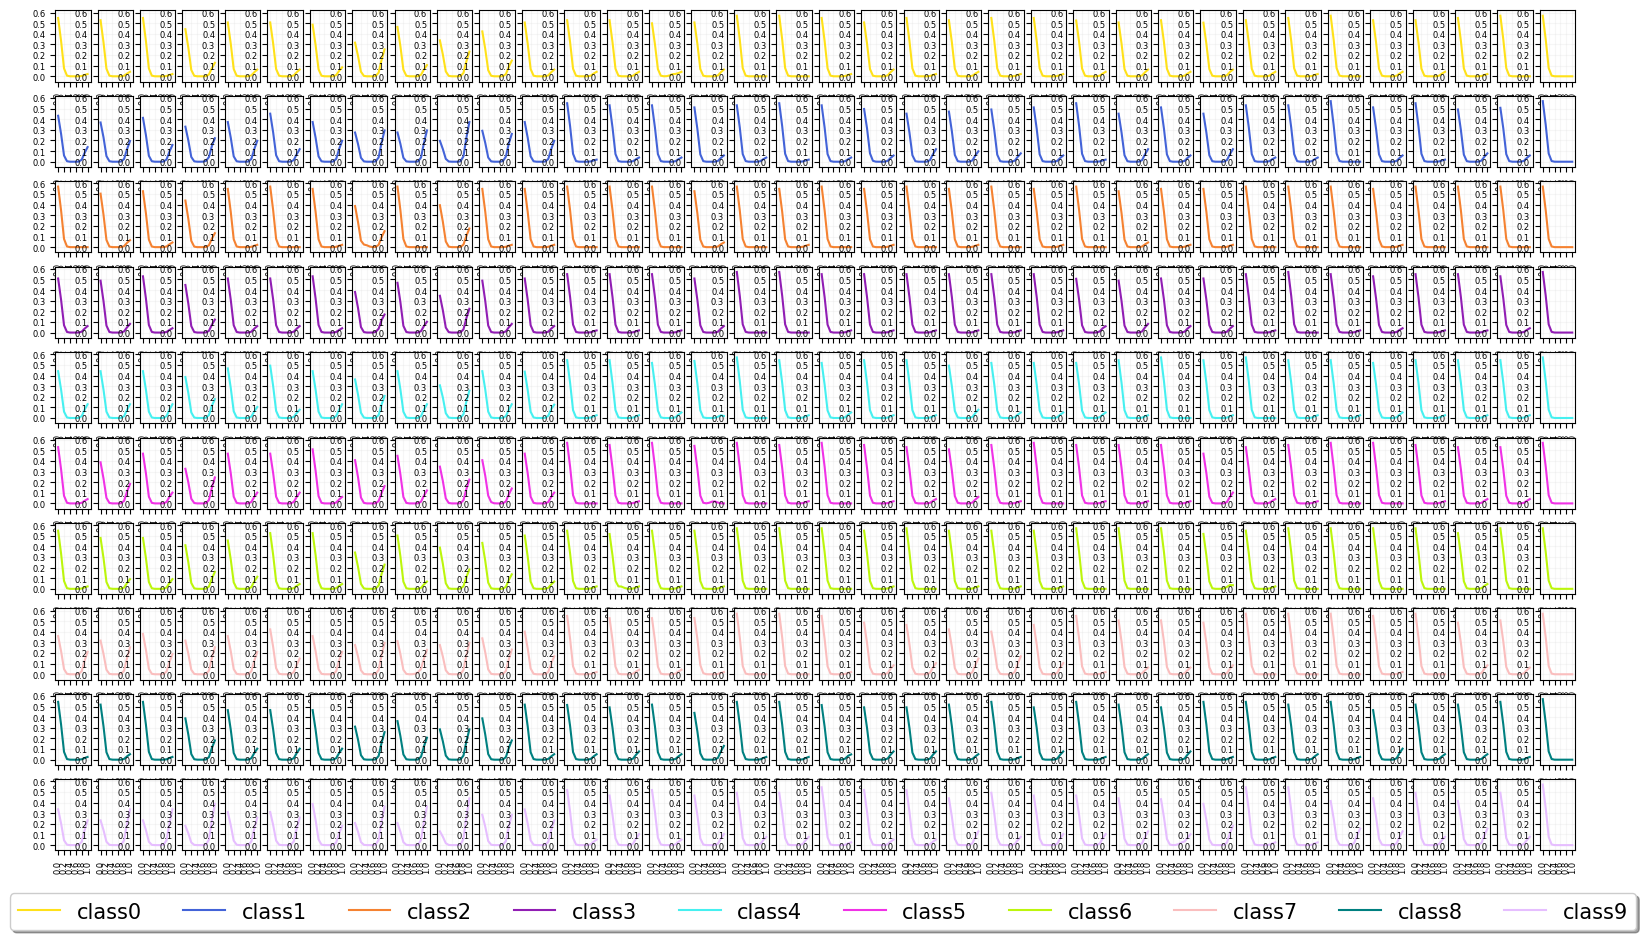

In [34]:
# extract features

features, labels = extract_features(nn.Sequential(trainer.model.feature_extractor), val_loader_labels, torch.device('cuda'))
# obtain feature distribution by class
feature_dist_by_class = obtain_feature_dist_by_class(
    trainer.model, features, labels
)
# visualize
no_classes = len(feature_dist_by_class)
feature_dist_arr = np.zeros(
    (no_classes, feature_dist_by_class[0].shape[1])
)
for c in feature_dist_by_class:
    feature_dist_arr[c] = feature_dist_by_class[c].cpu().numpy()
classes = ["class" + str(i) for i in range(no_classes)]

visualize_distributions(feature_dist_arr, classes)

#### calculate js divergence

In [46]:
def js_divergence(p,q):
	m = 0.5*(p+q)
	log_p_over_m = np.log2(p/m)
	log_q_over_m = np.log2(q/m)

	return 0.5*np.sum(p*log_p_over_m) + 0.5*np.sum(q*log_q_over_m)

JS divergence: min=0.02 - max=0.391 - mean=0.094 - std=0.078


C:\Users\kan_h\AppData\Local\Temp\ipykernel_35928\1456607838.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=0)
C:\Users\kan_h\AppData\Local\Temp\ipykernel_35928\1456607838.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(classes)


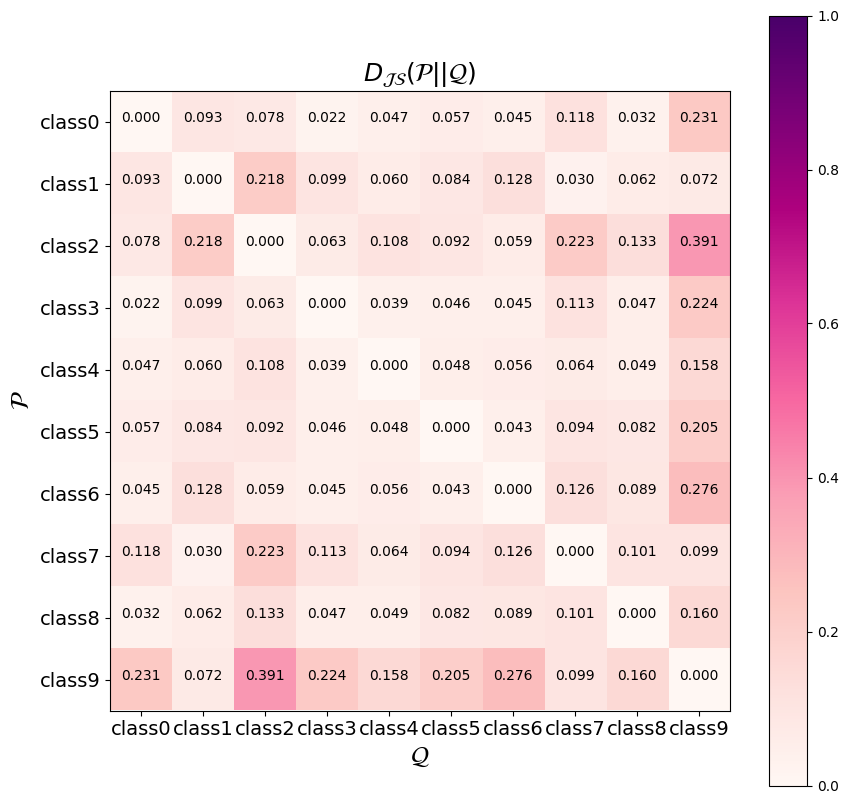

In [47]:
js_div_arr = np.zeros((10,10))
feature_distribution_norm = feature_dist_arr / 10
for i in range(10):
    p = np.clip(feature_distribution_norm[i,:], 1e-12, 1)
    for k in range(i, 10):
        q = np.clip(feature_distribution_norm[k,:], 1e-12, 1)
        js_div_arr[i,k] = js_divergence(p,q)
        js_div_arr[k,i] = js_div_arr[i,k]
print('JS divergence: min={:.2f} - max={:.3f} - mean={:.3f} - std={:.3f}'.format(
    np.amin(js_div_arr[js_div_arr>0]),np.amax(js_div_arr),np.mean(js_div_arr),np.std(js_div_arr)))
visualize_js_divergence(js_div_arr, classes)

#### Clustering

In [37]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from prettytable import PrettyTable
from scipy.optimize import linear_sum_assignment

In [38]:
def eval_clustering(estimator=None, name=None, data=None, labels=None):
	t0 = time()
	estimator.fit(data)
	homo_score = metrics.homogeneity_score(labels, estimator.labels_)
	comp_score = metrics.completeness_score(labels, estimator.labels_)
	v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
	adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
	adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)

	table = PrettyTable()
	table.field_names = ["init", "time", "homo", "compl", "v-meas", "ARI", "AMI"]
	table.add_row([name, round((time() - t0), 2), 
		round(homo_score, 3), 
		round(comp_score, 3), 
		round(v_measure_score, 3), 
		round(adjusted_rand_score, 3), 
		round(adjusted_mutual_info_score, 3)])
	print(table)

	clustering_scores = np.array([homo_score, comp_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score]).reshape((1,-1))
	return clustering_scores

In [39]:
features_flat = features.reshape(-1,36)

In [40]:
# cluster all data
num_clusters = len(classes)
estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
eval_clustering(estimator=estimator, name='all: spectral-nn', data=features_flat, labels=labels.cpu().squeeze())

estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
eval_clustering(estimator=estimator, name='all: kmeans++', data=features_flat, labels=labels.cpu().squeeze())

+------------------+------+-------+-------+--------+-------+-------+
|       init       | time |  homo | compl | v-meas |  ARI  |  AMI  |
+------------------+------+-------+-------+--------+-------+-------+
| all: spectral-nn | 0.18 | 0.102 | 0.107 | 0.105  | 0.019 | 0.026 |
+------------------+------+-------+-------+--------+-------+-------+
+---------------+------+-------+-------+--------+-------+-------+
|      init     | time |  homo | compl | v-meas |  ARI  |  AMI  |
+---------------+------+-------+-------+--------+-------+-------+
| all: kmeans++ | 0.03 | 0.122 |  0.15 | 0.135  | 0.016 | 0.052 |
+---------------+------+-------+-------+--------+-------+-------+


array([[0.12208433, 0.14990843, 0.13457322, 0.01615089, 0.0524665 ]])

In [41]:
def predict_cluster_labels(estimator, data):
	estimator.fit(data)
	pred = estimator.labels_

	return pred

In [42]:
nn_estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
kmeans_estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)

nn_predicted_labels = predict_cluster_labels(estimator=nn_estimator, data=features_flat)
kmeans_predicted_labels = predict_cluster_labels(estimator=kmeans_estimator, data=features_flat)

In [43]:
def compute_cluster_acc(truth_labels_arr, pred_arr):	
    cost_m = np.zeros((10,10))
    num_samples = np.zeros(10)
    for truth_val in range(10):
        ind = np.where(truth_labels_arr == truth_val)[0]
        num_samples[truth_val] = ind.shape[0]

        pred = pred_arr[ind]

        for predicted_val in range(10):

            temp_matching_pairs = np.where(pred == predicted_val)[0]

            cost_m[truth_val,predicted_val] = 1- (temp_matching_pairs.shape[0]/ind.shape[0])

    row_ind, col_ind = linear_sum_assignment(cost_m)

    cost = cost_m[row_ind,col_ind]

    clustering_acc = ((1-cost)*num_samples).sum() / num_samples.sum()
    return clustering_acc

In [44]:
nn_cluster_acc = compute_cluster_acc(
    labels.cpu(), nn_predicted_labels)
kmeans_cluster_acc = compute_cluster_acc(
    labels.cpu(), kmeans_predicted_labels)
print('nn_cluster_acc: {:.3f} - kmeans_cluster_acc: {:.3f}'.format(nn_cluster_acc, kmeans_cluster_acc))

nn_cluster_acc: 0.227 - kmeans_cluster_acc: 0.207
